#LOAD THE DATA

In [ ]:
import pandas as pd
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/train_values.csv
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/train_labels.csv
df_train_labels = pd.read_csv("train_labels.csv", index_col = "building_id")
df_train_values= pd.read_csv("train_values.csv", index_col = "building_id")
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
df = pd.read_csv("test_values.csv", index_col = 'building_id')
dff = df_train_values.join(df_train_labels)

--2022-12-13 18:43:03--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv [following]
--2022-12-13 18:43:04--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7815385 (7.5M) [text/plain]
Saving to: ‘test_values.csv’

test_values.csv     100%[===================>]   7.45M  --.-KB/s    in 0.07s   

2022-12-13 18:43:05 (104 MB/s) - ‘test_values.csv’ saved [7815385/7

In [ ]:
dff.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

#BASELINE

##Feature selection

In [ ]:
features_list = []
#dff = pd.get_dummies(df)
columns_list = list(dff.columns)
for i in columns_list:
  #and 'has' not in i
  #df[i].dtype == 'int64' and
  if dff[i].dtype == 'int64' and 'has' not in i:
    features_list.append(i) 
features_list

['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'count_families',
 'damage_grade']

##Train and test split

In [ ]:
from sklearn.model_selection import train_test_split
features_list.remove('damage_grade')

X = dff[features_list]
y = dff['damage_grade']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
X_train.reset_index(drop = True, inplace = True)
X_train.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
0,13,257,8352,3,25,2,5,1
1,6,1076,9202,3,40,10,8,0
2,7,838,10723,2,45,8,5,1
3,7,555,2763,2,30,7,4,1
4,17,682,1039,3,30,6,7,1


##KNN

###Setting parameters

Max Value uniform : 0.703880468150422 (9)
Max Value distance : 0.6992853031465847 (20)


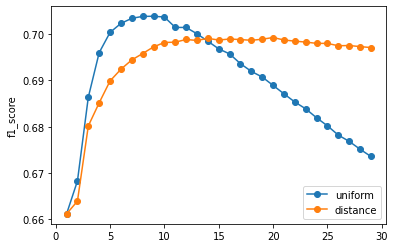

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

cv = KFold(n_splits = 5, shuffle = False)

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, metric='euclidean')
       for train_fold, test_fold in cv.split(X_train):
          # División train test aleatoria
          # train
          fx_train = X_train.iloc[train_fold]
          fy_train = y_train.iloc[train_fold]
          # test
          fx_test = X_train.iloc[test_fold]
          fy_test = y_train.iloc[test_fold]

          # entrenamiento y ejecución del modelo
          knn.fit( X = fx_train, y = fy_train)
          y_pred = knn.predict(X = fx_test)
          # evaluación del modelo
          f1 = f1_score(fy_test, y_pred, average = 'micro')
          fold_accuracy.append(f1)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('f1_score')    
  
plt.legend()
plt.show() 

###Prediction

In [ ]:
# constructor
n_neighbors = 8
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights)

# fit and predict
knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)

from sklearn import metrics
print ("f1:", metrics.f1_score(y_pred , y_test, average = 'micro'))

f1: 0.7064331075766006


###Prediction visualization

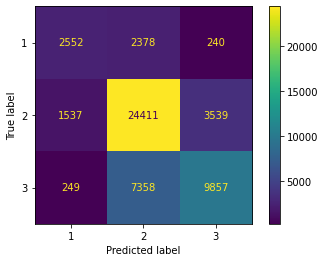

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.grid(False)
disp.figure_.savefig("confussion_matrix.pdf")
plt.show()

In [ ]:
predictions = knn.predict(df[features_list])
my_submission_knn = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission_knn.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,2


##Decision Trees

###Binary tree

Max Value uniform : 0.6851160782808903 (14)


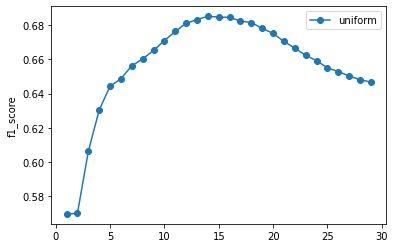

In [ ]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
from sklearn import tree

cv = KFold(n_splits = 5, shuffle = False)

total_scores = []
for i in range(1,30):
    fold_accuracy = []
    dt = tree.DecisionTreeClassifier(max_depth=i)
    for train_fold, test_fold in cv.split(X_train):
      # División train test aleatoria
      # train
      fx_train = X_train.iloc[train_fold]
      fy_train = y_train.iloc[train_fold]
      # test
      fx_test = X_train.iloc[test_fold]
      fy_test = y_train.iloc[test_fold]

      # entrenamiento y ejecución del modelo
      dt.fit( X = fx_train, y = fy_train)
      y_pred = dt.predict(X = fx_test)
      # evaluación del modelo
      mae = f1_score(fy_test, y_pred, average = 'micro')
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

plt.plot(range(1,len(total_scores)+1), total_scores, 
          marker='o', label=weights)
print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
plt.ylabel('f1_score')      
    

plt.legend()
plt.show() 

###Construction

In [ ]:
classifier = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
classifier.fit(X_train, y_train)

print ('Feature Relevances')
pd.DataFrame({'Attributes': features_list,
              'Decision Tree': classifier.feature_importances_})

Feature Relevances


,Attributes,Decision Tree
0,geo_level_1_id,0.947141
1,geo_level_2_id,0.000000
2,geo_level_3_id,0.000000
3,count_floors_pre_eq,0.000000
4,age,0.026683
5,area_percentage,0.000000
6,height_percentage,0.026176
7,count_families,0.000000


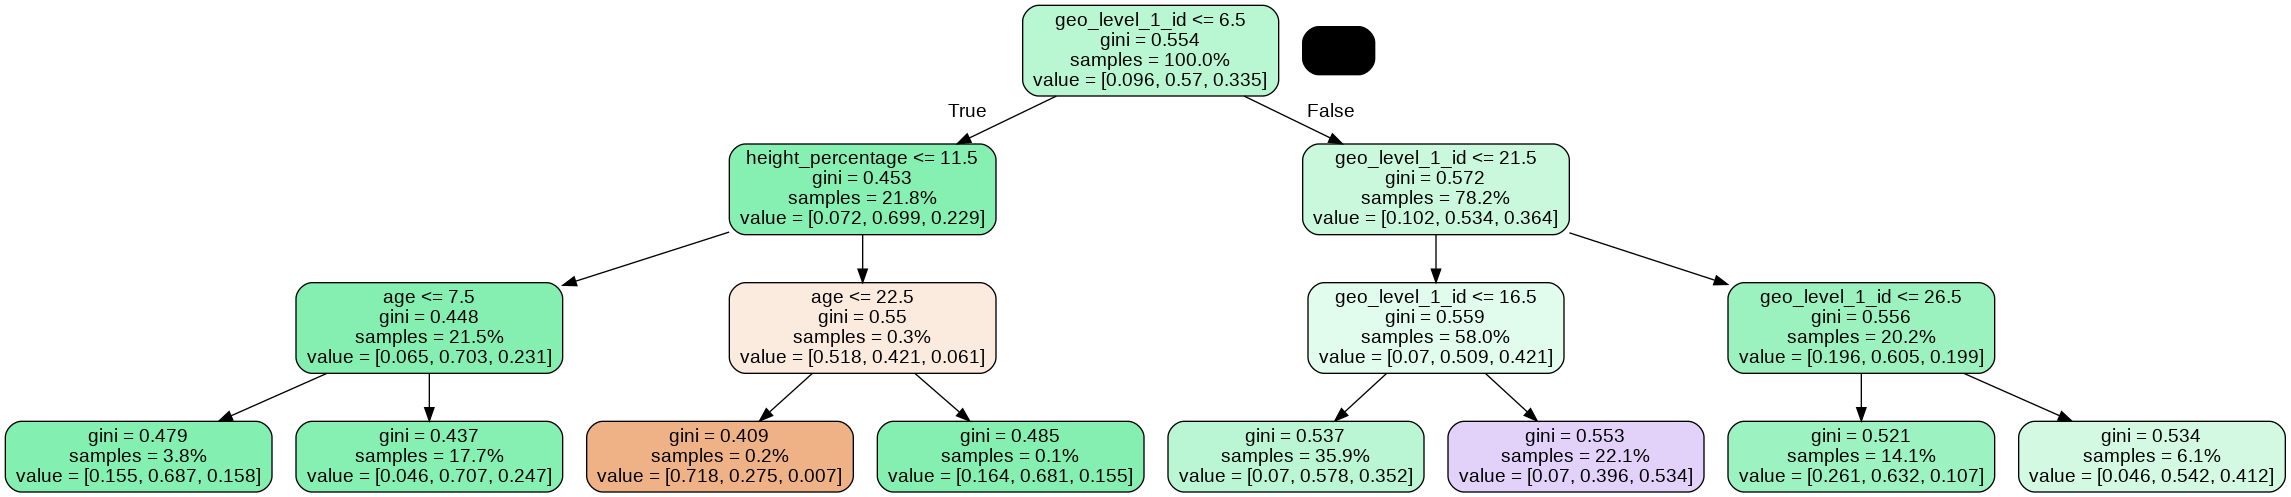

In [ ]:
from IPython.display import Image
from sklearn import tree
from io import StringIO

# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

dot_data = StringIO()
#tree.export_graphviz(clf, out_file=dot_data, feature_names=list(spy.drop(['CLASIFICADOR'], axis=1)))
tree.export_graphviz(classifier, out_file = dot_data, proportion = True, feature_names=features_list, rounded = True, filled = True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

###Prediction

In [ ]:
y_pred = dt.predict(X_test)

from sklearn import metrics
print ("f1:", metrics.f1_score(y_pred , y_test, average = 'micro'))

f1: 0.6435601772797912


In [ ]:
predictions = dt.predict(df[features_list])
my_submission_dt = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission_dt.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


#OPTIMIZED MODEL

##Hyperparameter optimization

In [ ]:
from sklearn.model_selection import train_test_split
#decision_trees_features = ['age', 'height_percentage', 'geo_level_1_id']
#features_list.remove('damage_grade')
X = dff[features_list]
y = dff['damage_grade']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
X_train.reset_index(drop = True, inplace = True)
X_train.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
0,16,352,4849,3,15,11,7,1
1,20,158,621,2,10,5,5,1
2,8,678,3362,3,35,3,8,1
3,8,1049,9986,2,15,10,6,1
4,13,606,10986,2,40,11,5,1


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
classifier = RandomForestClassifier(random_state=0)
param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128], # Number of trees in random forest
              "max_depth": [24, 12, 8, 4, 2, None], # Maximum number of levels in tree
              "criterion": ["gini"] #mse, mae
              }

rnd_regres = GridSearchCV(estimator = classifier, param_grid = param_dist, cv = 2, verbose=4)

# Fit the grid search model
rnd_regres.fit(X = X_train, y = y_train)
rnd_regres.best_params_

# choose the best
best_random = rnd_regres.best_estimator_

# fit
best_random.fit( X = X_train, y =y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END criterion=gini, max_depth=24, n_estimators=4;, score=0.644 total time=   0.5s
[CV 2/2] END criterion=gini, max_depth=24, n_estimators=4;, score=0.650 total time=   0.5s
[CV 1/2] END criterion=gini, max_depth=24, n_estimators=8;, score=0.667 total time=   0.9s
[CV 2/2] END criterion=gini, max_depth=24, n_estimators=8;, score=0.668 total time=   0.9s
[CV 1/2] END criterion=gini, max_depth=24, n_estimators=16;, score=0.681 total time=   1.8s
[CV 2/2] END criterion=gini, max_depth=24, n_estimators=16;, score=0.685 total time=   1.8s
[CV 1/2] END criterion=gini, max_depth=24, n_estimators=32;, score=0.689 total time=   3.5s
[CV 2/2] END criterion=gini, max_depth=24, n_estimators=32;, score=0.688 total time=   3.8s
[CV 1/2] END criterion=gini, max_depth=24, n_estimators=64;, score=0.692 total time=   7.1s
[CV 2/2] END criterion=gini, max_depth=24, n_estimators=64;, score=0.691 total time=   7.4s
[CV 1/2] END criterion=

RandomForestClassifier(max_depth=24, n_estimators=128, random_state=0)

###Prediction

f1: 0.7023453761090245


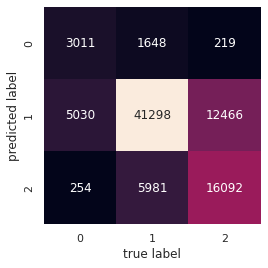

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn import metrics

y_pred = best_random.predict(X = X_test)
mat = confusion_matrix(y_test, y_pred)
print ("f1:", metrics.f1_score(y_pred , y_test, average = 'micro'))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
predictions = best_random.predict(df[features_list])
my_submission_hyper = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission_hyper.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


#Submission file

In [ ]:
my_submission_knn.to_csv('submission_knn.csv')
my_submission_dt.to_csv('submission_dt.csv')
my_submission_hyper.to_csv('submission_hyper.csv')

from google.colab import files

files.download('submission_knn.csv')
files.download('submission_dt.csv')
files.download('submission_hyper.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>